In [52]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import struct

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Vh/photonics-ring-resonator')) #Current directory

###############################################################
# WINDOWS PATH

#spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
#lumapi = importlib.util.module_from_spec(spec_win)
#os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
#sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Microring resonator/LumericalFiles/'))
#spec_win.loader.exec_module(lumapi)

In [53]:
lumR = lumapi.FDTD(filename='anel_lumerical.fsp',hide=False) 

In [54]:

def DeletarObj(nome, lum):
    lum.select(nome)
    lum.delete()


def CriarRect(nome, Xmin, Xmax, Y, Yspan, Zmin, Zmax, material, lum):
    
    lum.addrect()
    lum.set({
        "name": nome,
        "x min": Xmin,"y": Y,"z min": Zmin,
        "x max": Xmax, "y span": Yspan, "z max": Zmax,
        "material": material
        })

def altRect(nome, Xmin, Xmax, Y, Yspan, Zmin, Zmax, material, lum):
    DeletarObj(nome, lum)
    CriarRect(nome, Xmin, Xmax, Y, Yspan, Zmin, Zmax, material, lum)

def altRect2(nome, X, Xspan, Y, Yspan, Z, Zspan, material, lum):
    Xmin = X - (Xspan/2)
    Xmax = X + (Xspan/2)
    Zmin = Z - (Zspan/2)
    Zmax = Z + (Zspan/2)
    altRect(nome, Xmin, Xmax, Y, Yspan, Zmin, Zmax, material, lum)




In [55]:
RingLen = 0 # Length of straight sections of the ring
Radius = 3e-6 # Ring radius

RingSpan = 10e-6 # Length of straight waveguides
Gap = 150e-9 # Gap between waveguides and the ring

WGHeight = 0.22e-6 # height of the waveguide
WGWidth = 0.5e-6 # width of the waveguide base

FPoints = 8        # Monitor frequency points

In [56]:
lumR.switchtolayout()
# lumR.selectall()
# lumR.delete()
DeletarObj("ring resonator", lumR)
lumR.addobject("ring_resonator")
lumR.set({"x":-RingSpan/2, "y":0, "z":0,
          "Lc":RingLen,
          "x span":RingSpan,
          "radius":Radius,
          "gap":Gap,
          "base height":WGHeight,
          "base width":WGWidth})

lumR.setnamed("ring resonator::inner_bottom","enabled",0)
lumR.setnamed("ring resonator::outer_bottom","enabled",0)
lumR.setnamed("ring resonator::arc2","enabled",0)
lumR.setnamed("ring resonator::arc3","enabled",0)

altRect2("leg1", -RingLen-Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)
altRect2("leg2", RingLen+Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)

DeletarObj("FDTD", lumR)
lumR.addfdtd()
lumR.set({"x":0, "y":0.5*(Radius+3*WGWidth+Gap - Radius/4), "z":0,
          "x span":RingSpan, "y span":Radius+3*WGWidth+Gap+Radius/2, "z span":3*WGWidth,
          "background material": "SiO2 (Glass) - Palik",
          "mesh accuracy":4})

lumR.addport()
lumR.set({"x":-RingSpan/2.5, "y":Radius+WGWidth+Gap, "z":0,
          "y span":4*WGWidth, "z span":2*WGWidth})
lumR.addport()
lumR.set({"x":RingSpan/2.5, "y":Radius+WGWidth+Gap, "z":0,
          "y span":4*WGWidth, "z span":2*WGWidth,
          "direction":'Backward'})
lumR.addport()
lumR.set({"x":-RingLen-Radius, "y":-Radius/4, "z":0,
          "injection axis":'y-axis', "x span":4*WGWidth, "z span":2*WGWidth})
lumR.addport()
lumR.set({"x":RingLen+Radius, "y":-Radius/4, "z":0,
          "injection axis":'y-axis', "x span":4*WGWidth, "z span":2*WGWidth})

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

lumR.setglobalsource("wavelength start", 1.5e-6)
lumR.setglobalsource("wavelength stop", 1.6e-6)

1.0

## Mesh sweep

In [6]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 5       # Sweep points
SRange = [2,6]  # Sweep range
Name = "Mesh_sweep"

# Sweep creation
lumR.deletesweep(Name)
lumR.addsweep(0)
lumR.setsweep("sweep","name",Name)
lumR.setsweep(Name,"type","Ranges")
lumR.setsweep(Name,"number of points",SPoints)

MeshParameter = {"Name":"Mesh accuracy", "Type":"Number",
               "Parameter":"::model::FDTD::mesh accuracy",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

lumR.addsweepparameter(Name,MeshParameter)
lumR.addsweepresult(Name,Transmission_In)
lumR.addsweepresult(Name,Transmission_Pass)
lumR.addsweepresult(Name,Transmission_Drop)

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

Transmission In: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (8, 5)
ParSet shape: (1, 5)
Transmission Pass: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (8, 5)
ParSet shape: (1, 5)
Transmission Drop: dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
Subset shape: (8, 5)
ParSet shape: (1, 5)


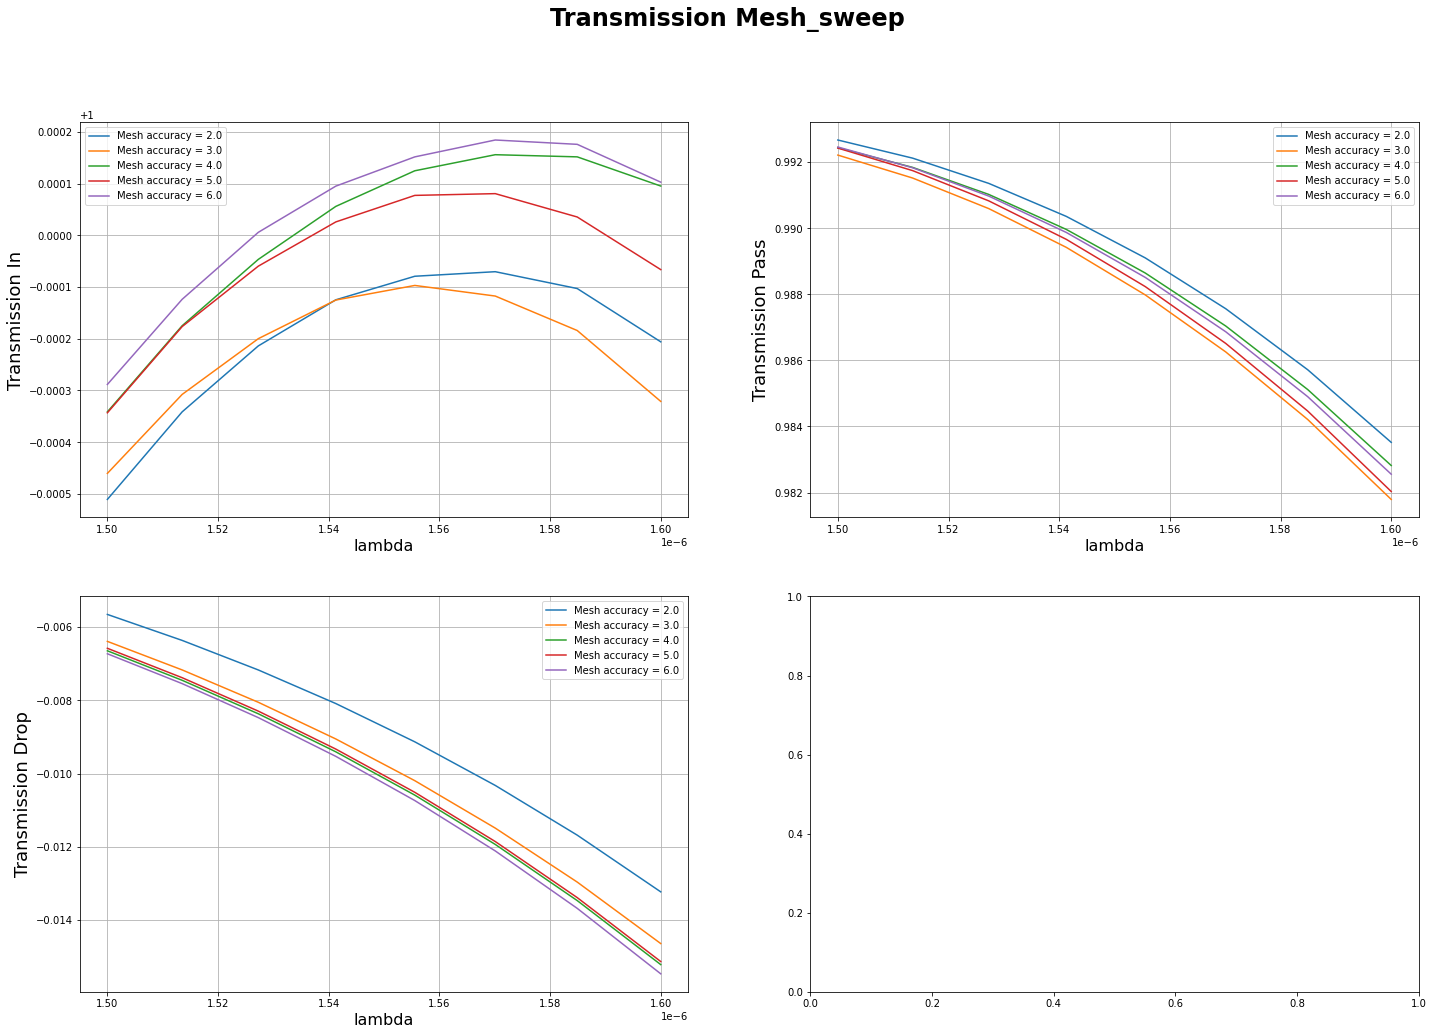

In [10]:
Name = "Mesh_sweep"
Parameters = ['Mesh accuracy','Mesh accuracy','Mesh accuracy'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)
Results = ['Transmission In','Transmission Pass','Transmission Drop']

winNum = int(1 + np.floor((len(Results) - 1)/2))  # Window line quantity
figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
figure.suptitle('Transmission ' + str(Name),fontsize=24, fontweight="bold")

for i in range(len(Results)):
    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet = dataSet[Parameters[i]]
    gparSet = dataSet[gParameter]

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet shape: " + str(np.shape(parSet)))

    # # Saving results
    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Parameters[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet,MSOutfile)
    # MSOutfile.close()

    for j in range(len(parSet[0,:])):
        index1 = int(np.floor(i/2))
        index2 = int(i%2)
        ax[index1][index2].plot(gparSet, np.transpose(subSet[:,j]), label=(str(Parameters[i])+' = '+str(round(parSet[0,j],9)) ))
        ax[index1][index2].set_xlabel(gParameter, fontsize=16)
        ax[index1][index2].set_ylabel(Results[i], fontsize=18)
        ax[index1][index2].grid(True)
        ax[index1][index2].legend(fontsize=10)
    
#plt.savefig("out.png", transparent=True)

## Gap and Lc sweep

In [57]:
# In order to fit the ring inside the FDTD solver
RingSpan = 15e-6


lumR.setnamed("ring resonator","x", -RingSpan/2)
lumR.setnamed("ring resonator","x span", RingSpan)
lumR.setnamed("FDTD", "x span", RingSpan)
lumR.setnamed("FDTD::ports::port 1", "x", -RingSpan/2.5)
lumR.setnamed("FDTD::ports::port 2", "x", RingSpan/2.5)


In [33]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 5      # Sweep points
S1Range = [2e-6,5e-6]  # Sweep range 1
S2Range = [100e-9,1000e-9]  # Sweep range 2
Name = "LcGap_sweep"

S1Values = np.linspace(S1Range[0],S1Range[1],SPoints)
S2Values = np.linspace(S2Range[0],S2Range[1],SPoints)

# Sweep creation
lumR.deletesweep(Name)
lumR.addsweep(0)
lumR.setsweep("sweep","name",Name)
lumR.setsweep(Name,"type","Values")
lumR.setsweep(Name,"number of points",SPoints**2)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc"}

GapParameter = {"Name":"Gap", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::gap"}

Leg1Parameter = {"Name":"Leg1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg1::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Leg2Parameter = {"Name":"Leg2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg2::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

Port3Parameter = {"Name":"Port3", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 3::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Port4Parameter = {"Name":"Port4", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 4::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

for i in range(SPoints):
    for j in range(SPoints):
        LCParameter['Value_'+str(SPoints*j+i+1)] = S1Values[i]
        GapParameter['Value_'+str(SPoints*j+i+1)] = S2Values[j]
        Leg1Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Leg2Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius
        Port3Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Port4Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

lumR.addsweepparameter(Name,LCParameter)
lumR.addsweepparameter(Name,GapParameter)
lumR.addsweepparameter(Name, Leg1Parameter)
lumR.addsweepparameter(Name, Leg2Parameter)
lumR.addsweepparameter(Name, Port3Parameter)
lumR.addsweepparameter(Name, Port4Parameter)
lumR.addsweepresult(Name,Transmission_In)
lumR.addsweepresult(Name,Transmission_Pass)
lumR.addsweepresult(Name,Transmission_Drop)

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

Transmission In: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 25)
ParSet_A shape: (1, 25)
ParSet_B shape: (1, 25)
Transmission Pass: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 25)
ParSet_A shape: (1, 25)
ParSet_B shape: (1, 25)
Transmission Drop: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 25)
ParSet_A shape: (1, 25)
ParSet_B shape: (1, 25)


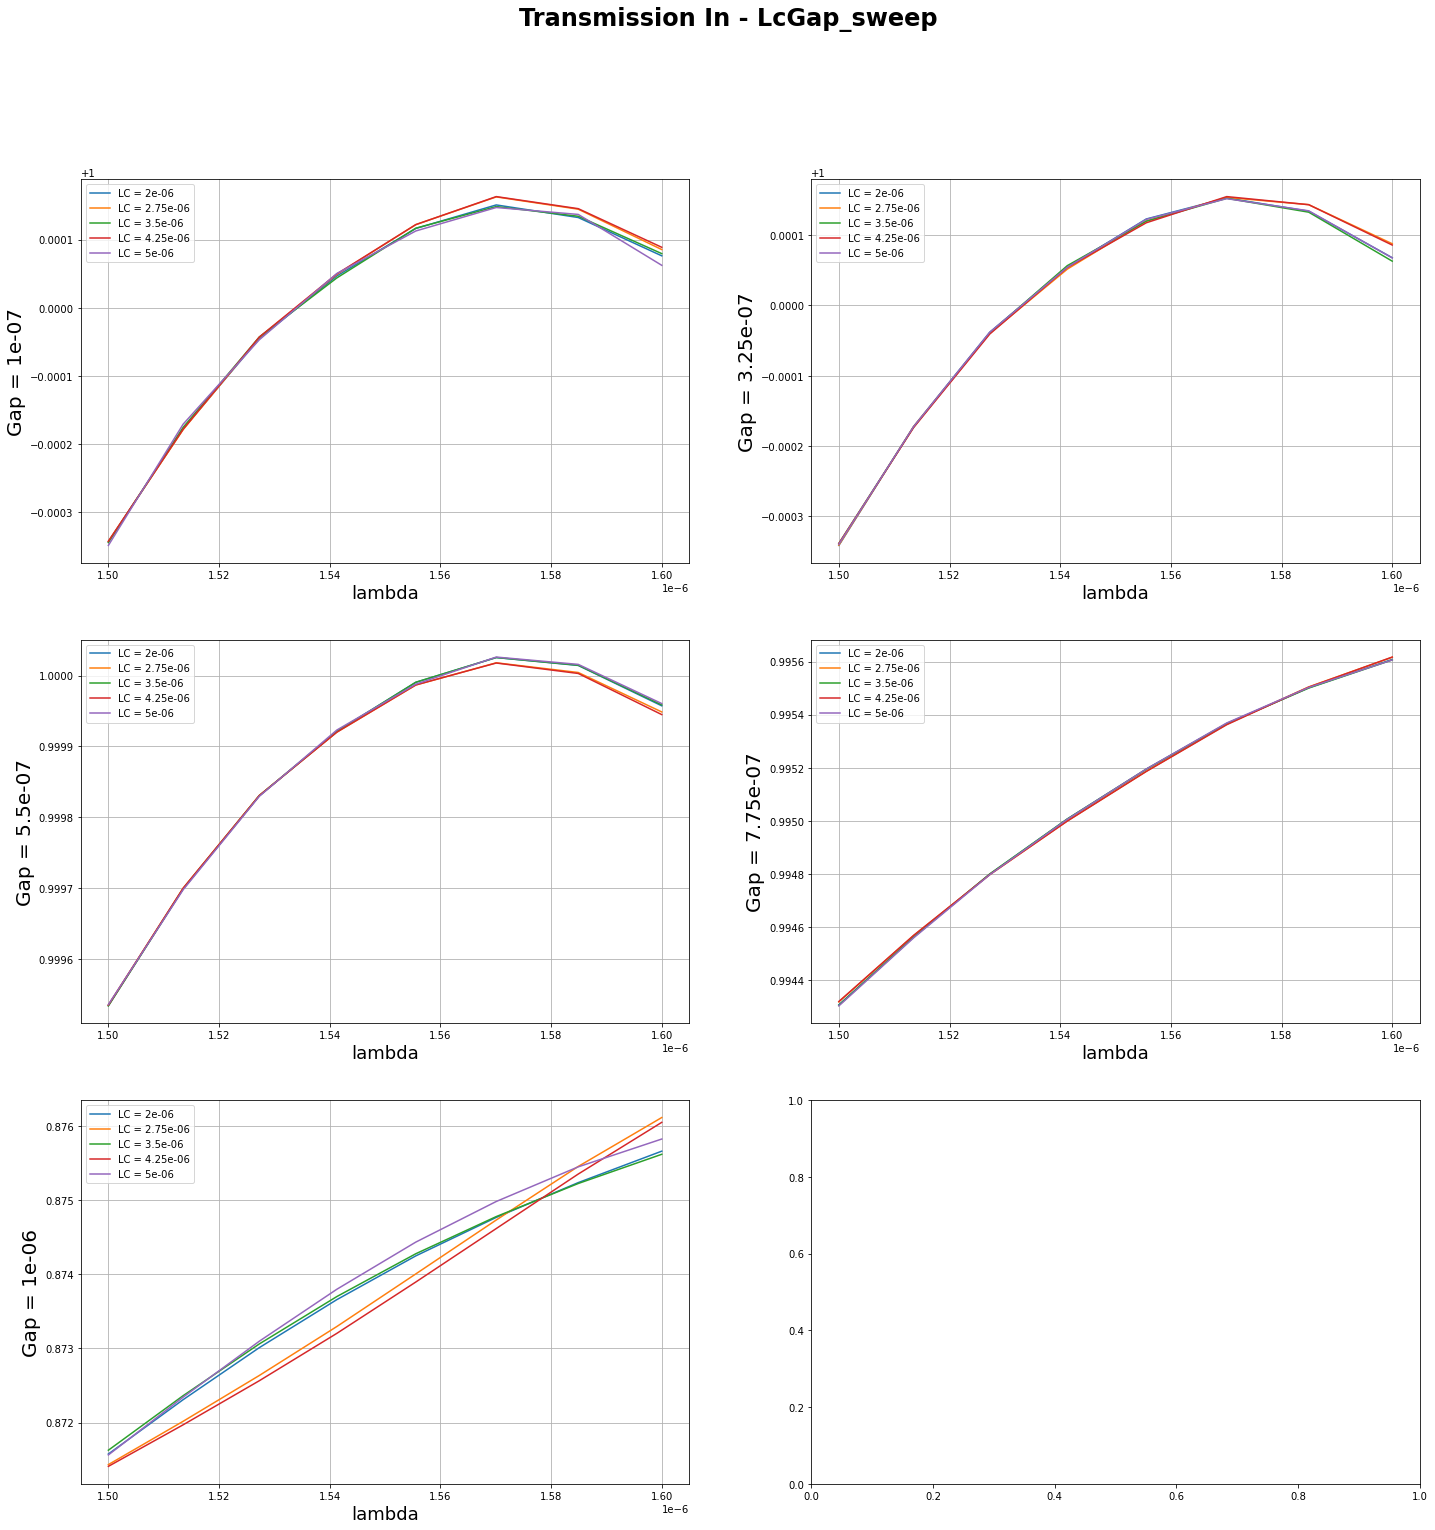

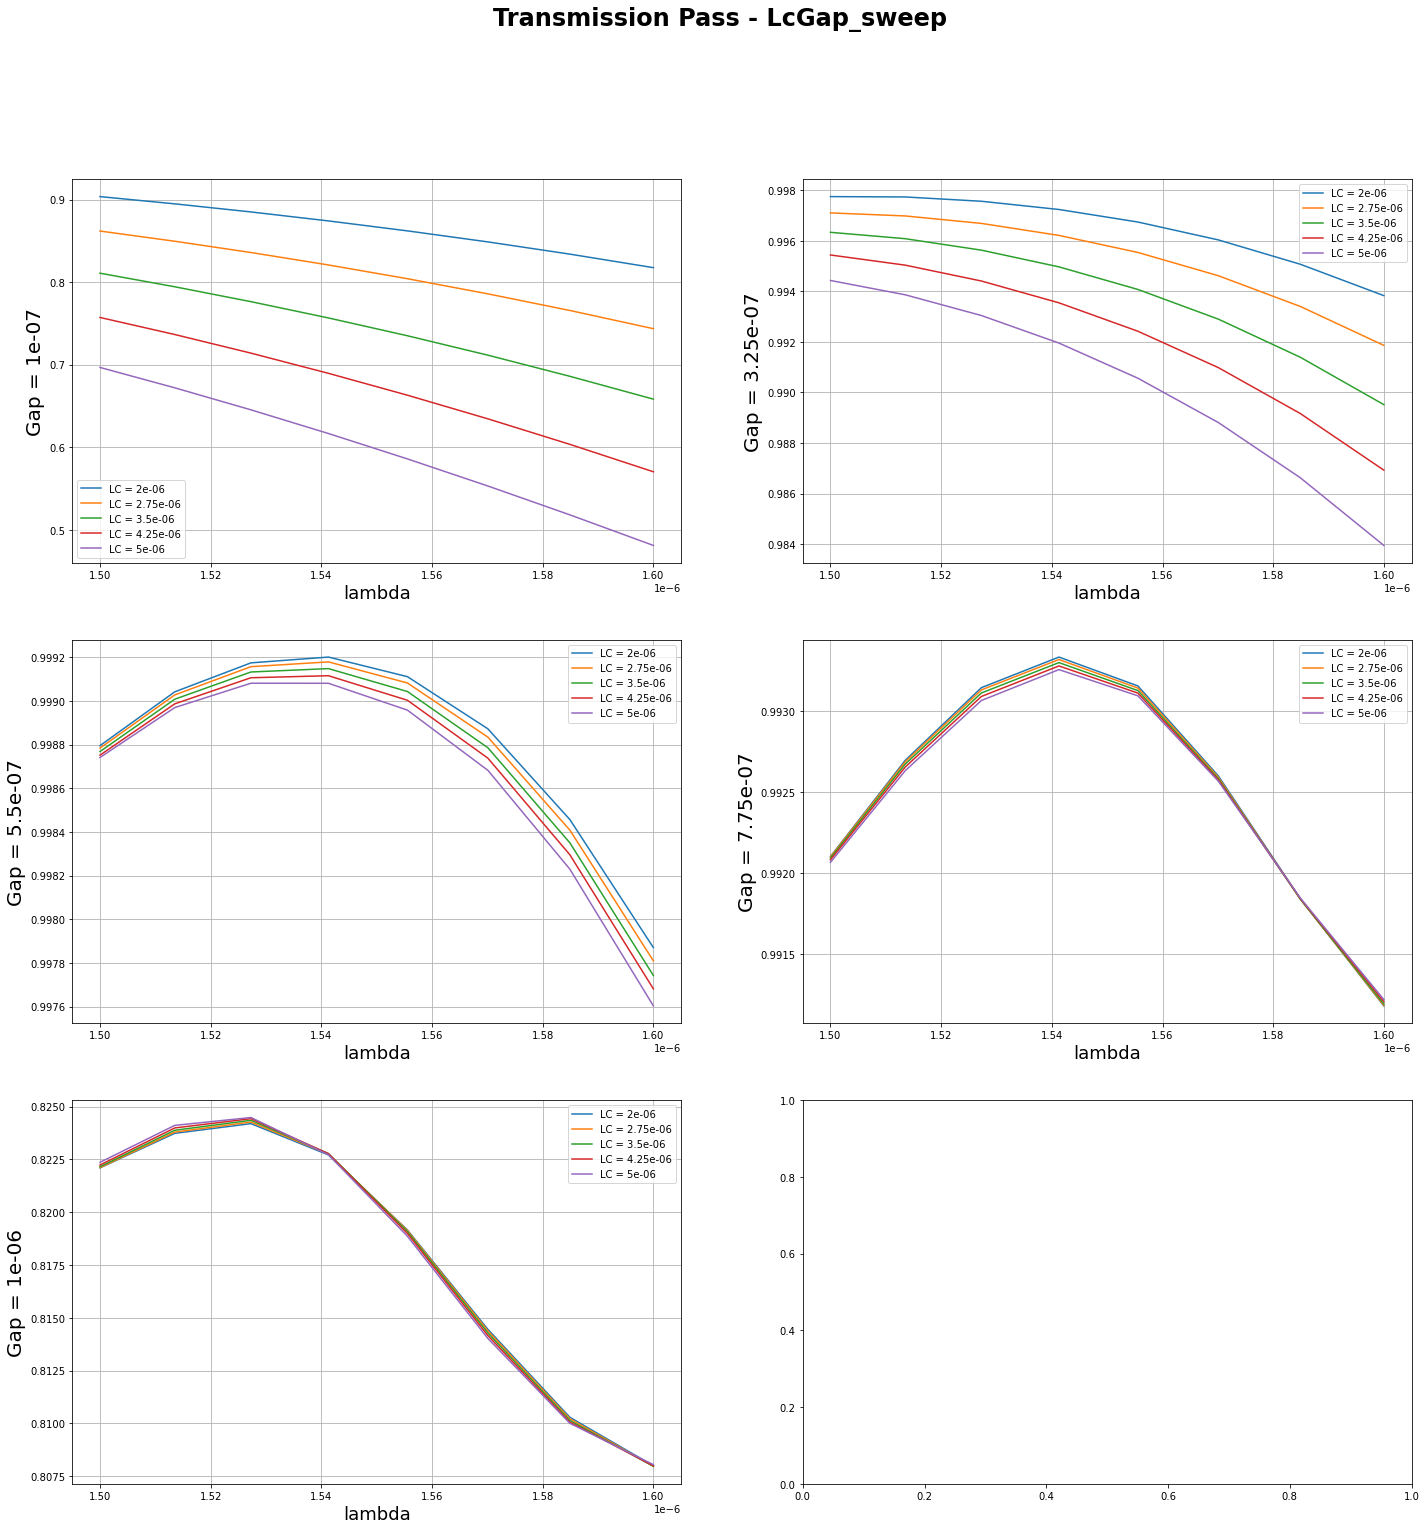

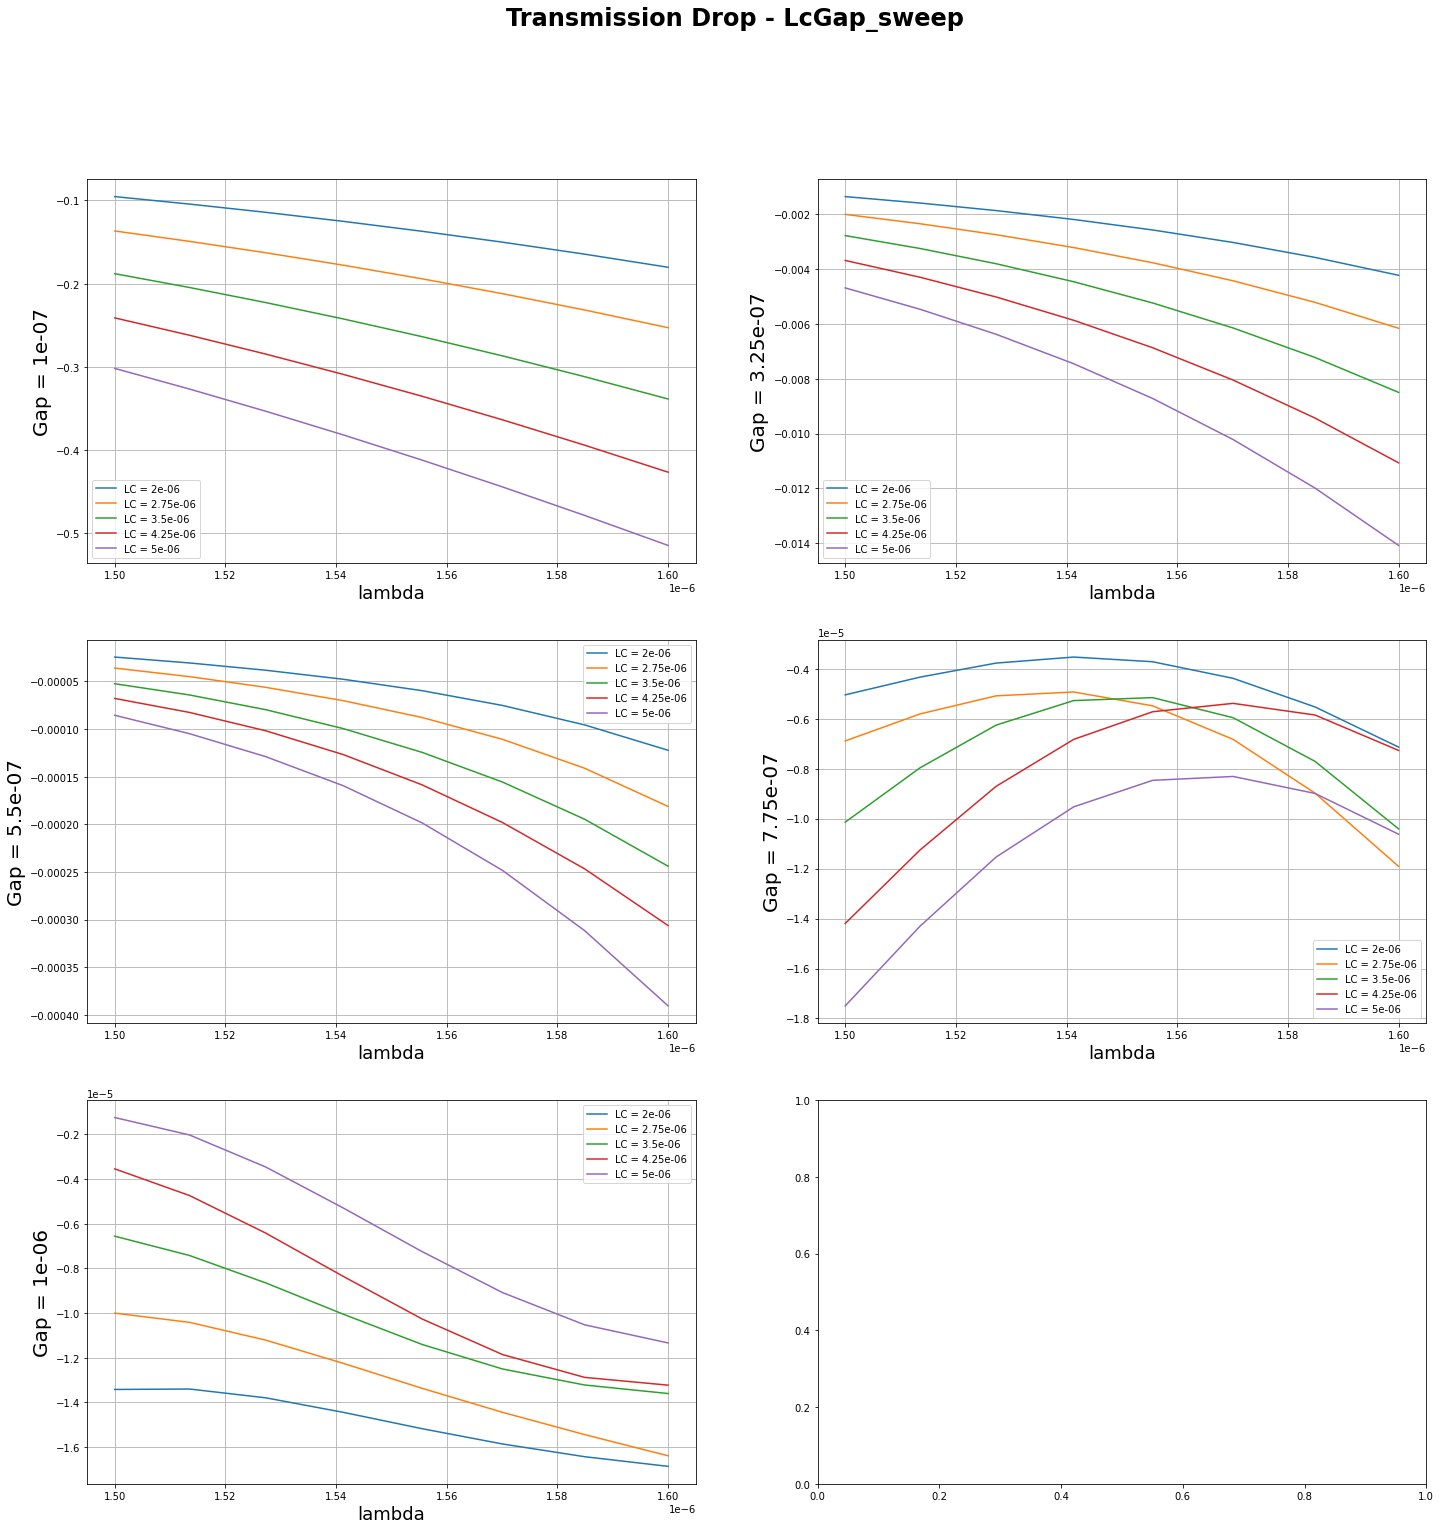

In [35]:
Name = "LcGap_sweep"
Parameters_A = ['LC','LC','LC'] # Specific parameters set (for specific result)
Parameters_B = ['Gap','Gap','Gap'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)

Results = ['Transmission In','Transmission Pass','Transmission Drop']
# All results: 'Transmission In','Transmission Pass','Transmission Drop'

for i in range(len(Results)):

    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet_A = dataSet[Parameters_A[i]]
    parSet_B = dataSet[Parameters_B[i]]
    gparSet = dataSet[gParameter]

    precision = int(np.sqrt(len(parSet_A[0,:]))) # Precision points quantity
    winNum = int((1+np.floor(precision))/2)              # Window line quantity
    figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
    figure.suptitle(str(Results[i]) + ' - ' + str(Name),fontsize=24, fontweight="bold")

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet_A shape: " + str(np.shape(parSet_A)))
    print("ParSet_B shape: " + str(np.shape(parSet_B)))

    # Saving results
    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_A[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_A,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_B[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_B,MSOutfile)
    # MSOutfile.close()

    for j in range(precision):
        index1 = int(np.floor(j/2))
        index2 = int(j%2)
        
        for k in range(precision):
            ax[index1][index2].plot(gparSet, np.transpose(subSet[:,k + precision*j]), label=(str(Parameters_A[i])+' = '+str(round(parSet_A[0 , k + precision*j] , 10)) ))
            ax[index1][index2].set_xlabel(gParameter, fontsize=18)
            ax[index1][index2].set_ylabel( Parameters_B[i] + ' = ' + str( round(parSet_B[0 , k + precision*j] , 10) ) , fontsize=20)
            ax[index1][index2].grid(True)
            ax[index1][index2].legend(fontsize=10)

    plt.savefig("out" + str(i) + ".png", transparent=True)

In [44]:
Radius = 3e-6
Radius = (2*np.pi*Radius + 2e-6)/(np.pi*2)
print(Radius)

lumR.switchtolayout()
# lumR.selectall()
# lumR.delete()
lumR.setnamed("ring resonator", "radius", Radius)

altRect2("leg1", -RingLen-Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)
altRect2("leg2", RingLen+Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)

lumR.setnamed("FDTD::ports::port 3", "x", -RingLen-Radius)
lumR.setnamed("FDTD::ports::port 4", "x", RingLen+Radius)

3.3183098861837906e-06


In [63]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 4      # Sweep points
S1Range = [0e-6,3e-6]  # Sweep range 1
S2Range = [100e-9,300e-9]  # Sweep range 2
Name = "LcGap_sweep"

S1Values = np.linspace(S1Range[0],S1Range[1],SPoints)
S2Values = np.linspace(S2Range[0],S2Range[1],SPoints)

# Sweep creation
lumR.deletesweep(Name)
lumR.addsweep(0)
lumR.setsweep("sweep","name",Name)
lumR.setsweep(Name,"type","Values")
lumR.setsweep(Name,"number of points",SPoints**2)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc"}

GapParameter = {"Name":"Gap", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::gap"}

Leg1Parameter = {"Name":"Leg1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg1::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Leg2Parameter = {"Name":"Leg2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg2::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

Port1Parameter = {"Name":"Port1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 1::y"}
Port2Parameter = {"Name":"Port2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 2::y"}

Port3Parameter = {"Name":"Port3", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 3::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Port4Parameter = {"Name":"Port4", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 4::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}


lumR.setnamed("ring resonator", "gap", Gap)
lumR.setnamed("FDTD::ports::port 1", "y", Radius+Gap+WGWidth)
lumR.setnamed("FDTD::ports::port 2", "y", Radius+Gap+WGWidth)
for i in range(SPoints):
    for j in range(SPoints):
        LCParameter['Value_'+str(SPoints*j+i+1)] = S1Values[i]
        GapParameter['Value_'+str(SPoints*j+i+1)] = S2Values[j]
        Port1Parameter['Value_'+str(SPoints*j+i+1)] = S2Values[j] + WGWidth + Radius 
        Port2Parameter['Value_'+str(SPoints*j+i+1)] = S2Values[j] + WGWidth + Radius 
        Leg1Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Leg2Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius
        Port3Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Port4Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

lumR.addsweepparameter(Name,LCParameter)
lumR.addsweepparameter(Name,GapParameter)
lumR.addsweepparameter(Name, Leg1Parameter)
lumR.addsweepparameter(Name, Leg2Parameter)
lumR.addsweepparameter(Name, Port1Parameter)
lumR.addsweepparameter(Name, Port2Parameter)
lumR.addsweepparameter(Name, Port3Parameter)
lumR.addsweepparameter(Name, Port4Parameter)
lumR.addsweepresult(Name,Transmission_In)
lumR.addsweepresult(Name,Transmission_Pass)
lumR.addsweepresult(Name,Transmission_Drop)

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

Transmission In: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port1', 'Port2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 16)
ParSet_A shape: (1, 16)
ParSet_B shape: (1, 16)
Transmission Pass: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port1', 'Port2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 16)
ParSet_A shape: (1, 16)
ParSet_B shape: (1, 16)
Transmission Drop: dict_keys(['lambda', 'f', 'LC', 'Gap', 'Leg1', 'Leg2', 'Port1', 'Port2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 16)
ParSet_A shape: (1, 16)
ParSet_B shape: (1, 16)


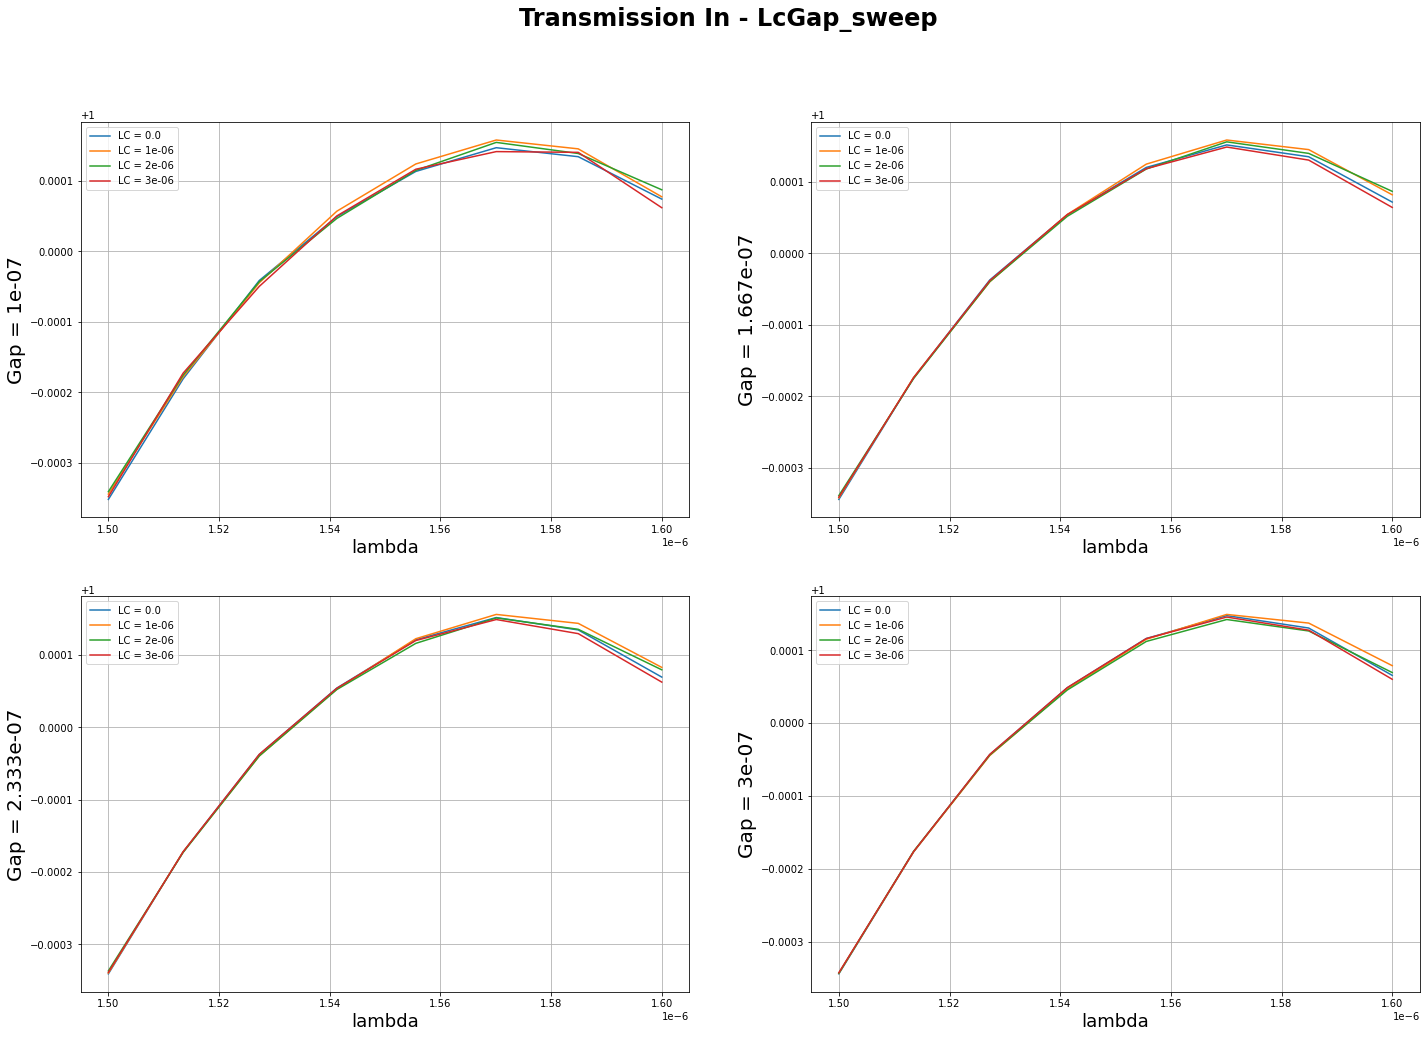

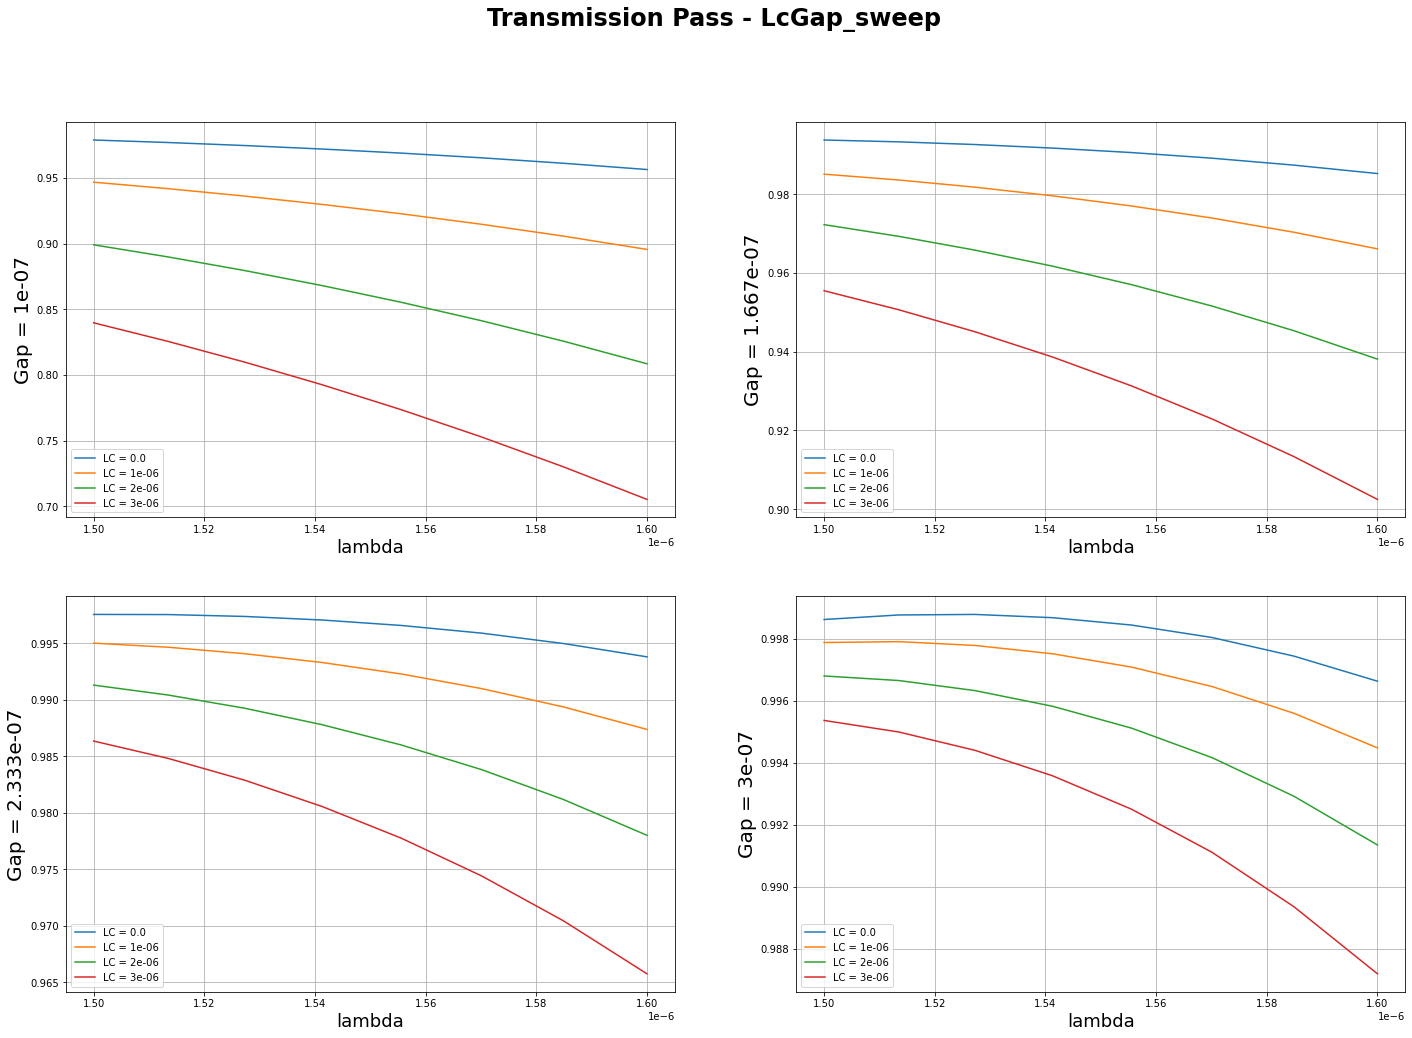

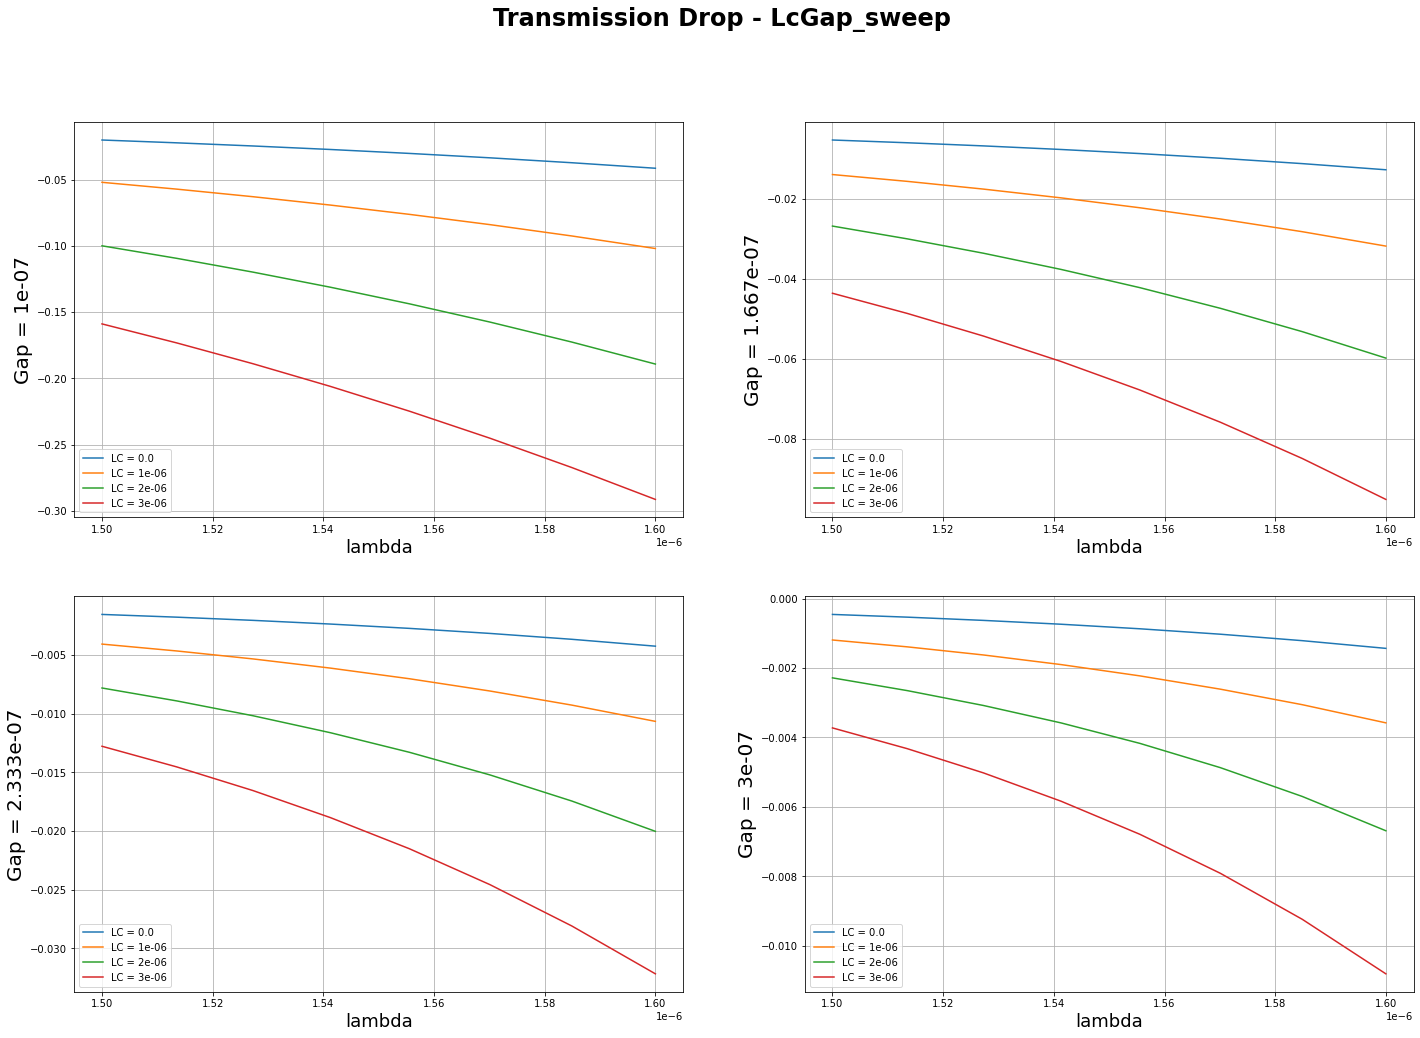

In [64]:
Name = "LcGap_sweep"
Parameters_A = ['LC','LC','LC'] # Specific parameters set (for specific result)
Parameters_B = ['Gap','Gap','Gap'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)

Results = ['Transmission In','Transmission Pass','Transmission Drop']
# All results: 'Transmission In','Transmission Pass','Transmission Drop'

for i in range(len(Results)):

    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet_A = dataSet[Parameters_A[i]]
    parSet_B = dataSet[Parameters_B[i]]
    gparSet = dataSet[gParameter]

    precision = int(np.sqrt(len(parSet_A[0,:]))) # Precision points quantity
    winNum = int((1+np.floor(precision))/2)              # Window line quantity
    figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
    figure.suptitle(str(Results[i]) + ' - ' + str(Name),fontsize=24, fontweight="bold")

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet_A shape: " + str(np.shape(parSet_A)))
    print("ParSet_B shape: " + str(np.shape(parSet_B)))

    # Saving results
    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_A[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_A,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_B[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_B,MSOutfile)
    # MSOutfile.close()

    for j in range(precision):
        index1 = int(np.floor(j/2))
        index2 = int(j%2)
        
        for k in range(precision):
            ax[index1][index2].plot(gparSet, np.transpose(subSet[:,k + precision*j]), label=(str(Parameters_A[i])+' = '+str(round(parSet_A[0 , k + precision*j] , 10)) ))
            ax[index1][index2].set_xlabel(gParameter, fontsize=18)
            ax[index1][index2].set_ylabel( Parameters_B[i] + ' = ' + str( round(parSet_B[0 , k + precision*j] , 10) ) , fontsize=20)
            ax[index1][index2].grid(True)
            ax[index1][index2].legend(fontsize=10)

    plt.savefig("out" + str(i) + ".png", transparent=True)

In [65]:
Radius = 3e-6
Radius = (2*np.pi*Radius + (2+1)*1e-6)/(np.pi*2)
print(Radius)

lumR.switchtolayout()
# lumR.selectall()
# lumR.delete()
lumR.setnamed("ring resonator", "radius", Radius)

altRect2("leg1", -RingLen-Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)
altRect2("leg2", RingLen+Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)

lumR.setnamed("FDTD::ports::port 3", "x", -RingLen-Radius)
lumR.setnamed("FDTD::ports::port 4", "x", RingLen+Radius)

3.477464829275686e-06


In [66]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 6       # Sweep points
S1Range = [0e-6,2e-6]  # Sweep range 1
S2Range = [100e-9,150e-9]  # Sweep range 2
Name = "LcGap_sweep"

S1Values = np.linspace(S1Range[0],S1Range[1],SPoints)
S2Values = np.linspace(S2Range[0],S2Range[1],SPoints)

# Sweep creation
lumR.deletesweep(Name)
lumR.addsweep(0)
lumR.setsweep("sweep","name",Name)
lumR.setsweep(Name,"type","Values")
lumR.setsweep(Name,"number of points",SPoints**2)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc"}

GapParameter = {"Name":"Gap", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::gap"}

Leg1Parameter = {"Name":"Leg1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg1::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Leg2Parameter = {"Name":"Leg2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg2::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

Port1Parameter = {"Name":"Port1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 1::y"}
Port2Parameter = {"Name":"Port2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 2::y"}

Port3Parameter = {"Name":"Port3", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 3::x"}
            #    "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Port4Parameter = {"Name":"Port4", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 4::x"}
            #    "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}


lumR.setnamed("ring resonator", "gap", Gap)
lumR.setnamed("FDTD::ports::port 1", "y", Radius+Gap+WGWidth)
lumR.setnamed("FDTD::ports::port 2", "y", Radius+Gap+WGWidth)
for i in range(SPoints):
    for j in range(SPoints):
        LCParameter['Value_'+str(SPoints*j+i+1)] = S1Values[i]
        GapParameter['Value_'+str(SPoints*j+i+1)] = S2Values[j]
        Port1Parameter['Value_'+str(SPoints*j+i+1)] = S2Values[j] + WGWidth + Radius 
        Port2Parameter['Value_'+str(SPoints*j+i+1)] = S2Values[j] + WGWidth + Radius 
        Leg1Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Leg2Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius
        Port3Parameter['Value_'+str(SPoints*j+i+1)] = -(S1Values[i]/2)-RingLen-Radius
        Port4Parameter['Value_'+str(SPoints*j+i+1)] = (S1Values[i]/2)+RingLen+Radius

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

lumR.addsweepparameter(Name,LCParameter)
lumR.addsweepparameter(Name,GapParameter)
lumR.addsweepparameter(Name, Leg1Parameter)
lumR.addsweepparameter(Name, Leg2Parameter)
lumR.addsweepparameter(Name, Port1Parameter)
lumR.addsweepparameter(Name, Port2Parameter)
lumR.addsweepparameter(Name, Port3Parameter)
lumR.addsweepparameter(Name, Port4Parameter)
lumR.addsweepresult(Name,Transmission_In)
lumR.addsweepresult(Name,Transmission_Pass)
lumR.addsweepresult(Name,Transmission_Drop)

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

In [ ]:
Name = "LcGap_sweep"
Parameters_A = ['LC','LC','LC'] # Specific parameters set (for specific result)
Parameters_B = ['Gap','Gap','Gap'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)

Results = ['Transmission In','Transmission Pass','Transmission Drop']
# All results: 'Transmission In','Transmission Pass','Transmission Drop'

for i in range(len(Results)):

    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet_A = dataSet[Parameters_A[i]]
    parSet_B = dataSet[Parameters_B[i]]
    gparSet = dataSet[gParameter]

    precision = int(np.sqrt(len(parSet_A[0,:]))) # Precision points quantity
    winNum = int((1+np.floor(precision))/2)              # Window line quantity
    figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
    figure.suptitle(str(Results[i]) + ' - ' + str(Name),fontsize=24, fontweight="bold")

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet_A shape: " + str(np.shape(parSet_A)))
    print("ParSet_B shape: " + str(np.shape(parSet_B)))

    # Saving results
    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_A[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_A,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_B[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_B,MSOutfile)
    # MSOutfile.close()

    for j in range(precision):
        index1 = int(np.floor(j/2))
        index2 = int(j%2)
        
        for k in range(precision):
            ax[index1][index2].plot(gparSet, np.transpose(subSet[:,k + precision*j]), label=(str(Parameters_A[i])+' = '+str(round(parSet_A[0 , k + precision*j] , 10)) ))
            ax[index1][index2].set_xlabel(gParameter, fontsize=18)
            ax[index1][index2].set_ylabel( Parameters_B[i] + ' = ' + str( round(parSet_B[0 , k + precision*j] , 10) ) , fontsize=20)
            ax[index1][index2].grid(True)
            ax[index1][index2].legend(fontsize=10)

    plt.savefig("out" + str(i) + ".png", transparent=True)

In [59]:
# Gap change:
Gap = 1e-7
lumR.setnamed("ring resonator", "gap", Gap)
lumR.setnamed("FDTD::ports::port 1", "y", Radius+Gap+WGWidth)
lumR.setnamed("FDTD::ports::port 2", "y", Radius+Gap+WGWidth)



# Radius change:
Radius = 3e-6
Radius = (2*np.pi*Radius + (2+1)*1e-6)/(2*np.pi)


lumR.switchtolayout()
# lumR.selectall()
# lumR.delete()
lumR.setnamed("ring resonator", "radius", Radius)

altRect2("leg1", -RingLen-Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)
altRect2("leg2", RingLen+Radius, WGWidth, -Radius/4, Radius/2, 0, WGHeight, "Si (Silicon) - Palik", lumR)

lumR.setnamed("FDTD::ports::port 3", "x", -RingLen-Radius)
lumR.setnamed("FDTD::ports::port 4", "x", RingLen+Radius)

In [61]:
# Sweep configs
FPoints = 8        # Monitor frequency points
SPoints = 4        # Sweep points
SRange = [0,2e-6]  # Sweep range
Name = "Lc_sweep"

# Sweep creation
lumR.deletesweep(Name)
lumR.addsweep(0)
lumR.setsweep("sweep","name",Name)
lumR.setsweep(Name,"type","Ranges")
lumR.setsweep(Name,"number of points",SPoints)

LCParameter = {"Name":"LC", "Type":"Length", "Units":"microns",
               "Parameter":"::model::ring resonator::Lc",
               "Start":SRange[0], "Stop":SRange[1]}


Leg1Parameter = {"Name":"Leg1", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg1::x",
               "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Leg2Parameter = {"Name":"Leg2", "Type":"Length", "Units":"microns",
               "Parameter":"::model::leg2::x",
               "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

Port3Parameter = {"Name":"Port3", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 3::x",
               "Start":-(SRange[0]/2)-RingLen-Radius, "Stop":-(SRange[1]/2)-RingLen-Radius}
Port4Parameter = {"Name":"Port4", "Type":"Length", "Units":"microns",
               "Parameter":"::model::FDTD::ports::port 4::x",
               "Start":(SRange[0]/2)+RingLen+Radius, "Stop":(SRange[1]/2)+RingLen+Radius}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Pass = {"Name":"Transmission Pass",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Drop = {"Name":"Transmission Drop",
                     "Result":"::model::FDTD::ports::port 4::T"}

lumR.addsweepparameter(Name,LCParameter)
lumR.addsweepparameter(Name, Leg1Parameter)
lumR.addsweepparameter(Name, Leg2Parameter)
lumR.addsweepparameter(Name, Port3Parameter)
lumR.addsweepparameter(Name, Port4Parameter)
lumR.addsweepresult(Name,Transmission_In)
lumR.addsweepresult(Name,Transmission_Pass)
lumR.addsweepresult(Name,Transmission_Drop)

lumR.select('FDTD::ports')
lumR.set('monitor frequency points',FPoints)

Transmission In: dict_keys(['lambda', 'f', 'LC', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 4)
ParSet shape: (1, 4)
Transmission Pass: dict_keys(['lambda', 'f', 'LC', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 4)
ParSet shape: (1, 4)
Transmission Drop: dict_keys(['lambda', 'f', 'LC', 'Leg1', 'Leg2', 'Port3', 'Port4', 'T', 'Lumerical_dataset'])
Subset shape: (8, 4)
ParSet shape: (1, 4)


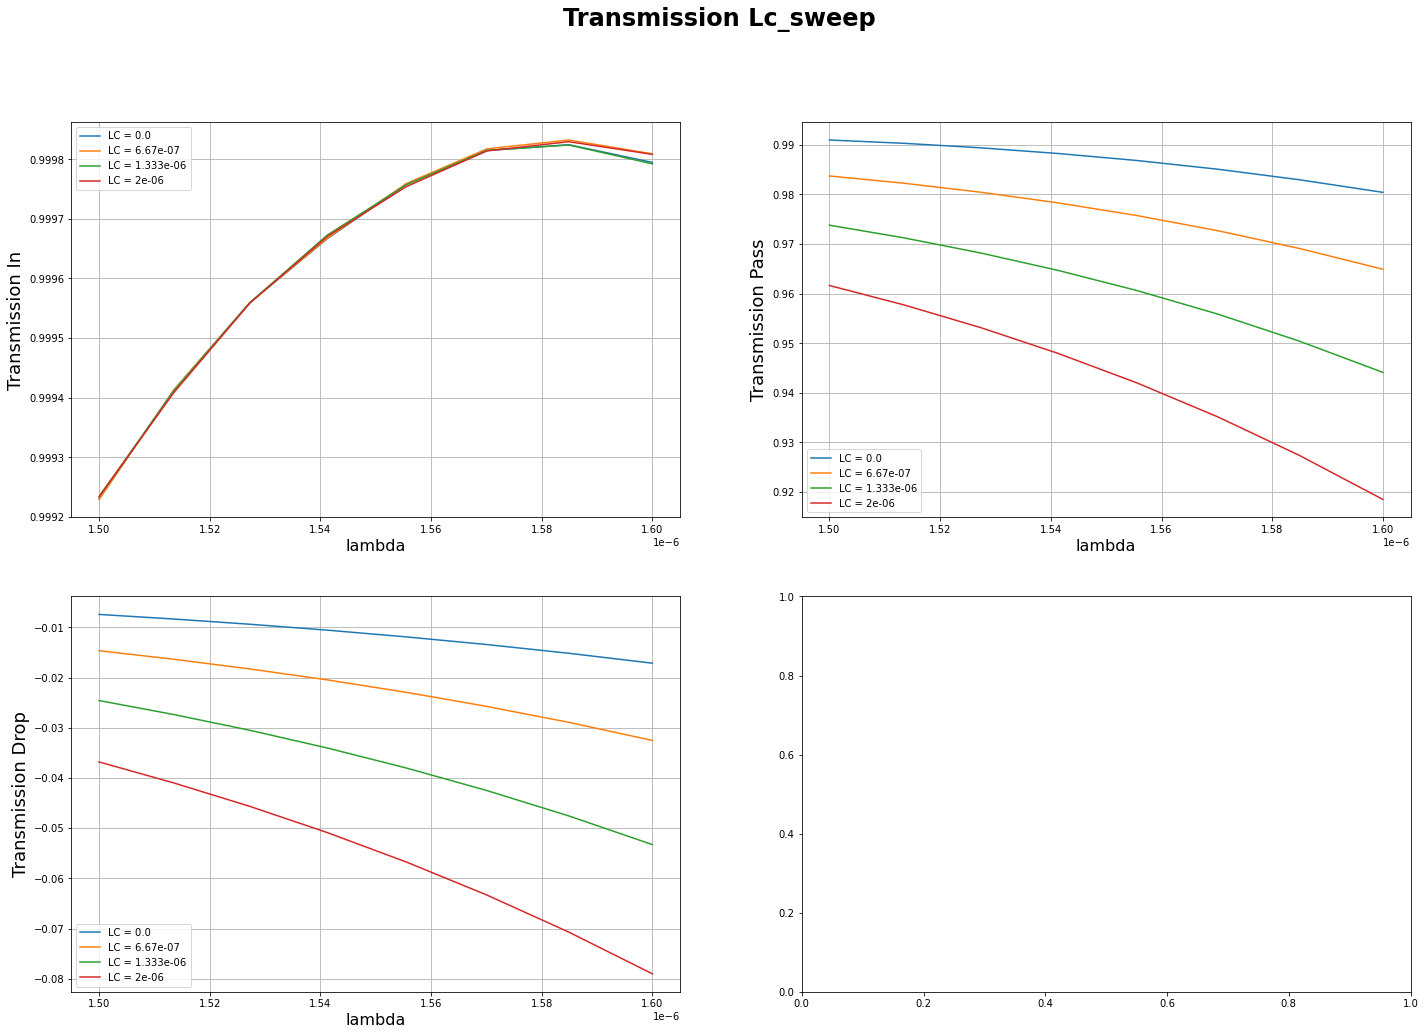

In [62]:

Parameters = ['LC','LC','LC'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)
Results = ['Transmission In','Transmission Pass','Transmission Drop']

winNum = int(1 + np.floor((len(Results) - 1)/2))  # Window line quantity
figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
figure.suptitle('Transmission ' + str(Name),fontsize=24, fontweight="bold")

for i in range(len(Results)):
    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet = dataSet[Parameters[i]]
    gparSet = dataSet[gParameter]

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet shape: " + str(np.shape(parSet)))

    # # Saving results
    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/MeshSweep','Data '+str(Parameters[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet,MSOutfile)
    # MSOutfile.close()

    for j in range(len(parSet[0,:])):
        index1 = int(np.floor(i/2))
        index2 = int(i%2)
        ax[index1][index2].plot(gparSet, np.transpose(subSet[:,j]), label=(str(Parameters[i])+' = '+str(round(parSet[0,j],9)) ))
        ax[index1][index2].set_xlabel(gParameter, fontsize=16)
        ax[index1][index2].set_ylabel(Results[i], fontsize=18)
        ax[index1][index2].grid(True)
        ax[index1][index2].legend(fontsize=10)
    
#plt.savefig("out.png", transparent=True)

In [ ]:
Parameters_A = ['LC','LC','LC'] # Specific parameters set (for specific result)
Parameters_B = ['Gap','Gap','Gap'] # Specific parameters set (for specific result)
gParameter = "lambda"                                          # General parameter (for all results)

Results = ['Transmission In','Transmission Pass','Transmission Drop']
# All results: 'Transmission In','Transmission Pass','Transmission Drop'

for i in range(len(Results)):

    dataSet = lumR.getsweepresult(Name, Results[i])
    subSet = dataSet['T']
    parSet_A = dataSet[Parameters_A[i]]
    parSet_B = dataSet[Parameters_B[i]]
    gparSet = dataSet[gParameter]

    precision = int(np.sqrt(len(parSet_A[0,:]))) # Precision points quantity
    winNum = int((1+np.floor(precision))/2)              # Window line quantity
    figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
    figure.suptitle(str(Results[i]) + ' - ' + str(Name),fontsize=24, fontweight="bold")

    print(str(Results[i]) + ": " + str(dataSet.keys()))
    print("Subset shape: " + str(np.shape(subSet)))
    print("ParSet_A shape: " + str(np.shape(parSet_A)))
    print("ParSet_B shape: " + str(np.shape(parSet_B)))

    # Saving results
    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Results[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(subSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(gParameter))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(gparSet,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_A[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_A,MSOutfile)
    # MSOutfile.close()

    # completeName = os.path.join('../SavedData/' + str(Name),'Data '+str(Parameters_B[i]))
    # MSOutfile = open(completeName,'wb')
    # plk.dump(parSet_B,MSOutfile)
    # MSOutfile.close()

    for j in range(precision):
        index1 = int(np.floor(j/2))
        index2 = int(j%2)
        
        for k in range(precision):
            ax[index1][index2].plot(gparSet, np.transpose(subSet[:,k + precision*j]), label=(str(Parameters_A[i])+' = '+str(round(parSet_A[0 , k + precision*j] , 10)) ))
            ax[index1][index2].set_xlabel(gParameter, fontsize=18)
            ax[index1][index2].set_ylabel( Parameters_B[i] + ' = ' + str( round(parSet_B[0 , k + precision*j] , 10) ) , fontsize=20)
            ax[index1][index2].grid(True)
            ax[index1][index2].legend(fontsize=10)

    plt.savefig("out" + str(i) + ".png", transparent=True)